# MODELO LINEAL

### AUTOR: CARLOS MOROCHO

### 1) Formulación del problema

En este proyecto se aplicará el modelo de regresión logística para realizar la predicción de casos nuevos confirmados de COVID-19 en el Ecuador. Para este propósito se utilizaran como variables primordiales el número de casos confirmados y la fecha en formato de días. Además se realizara una comparación con el modelo líneal para ver cual se ajusta mejor a los datos analizados.

### 2) Definición del sistema

Para realizar la simulación se utilizará un cuaderno de Python (Jupyter Notebook), en el que el usuario podra ir ejecutando segmentos de código y ver como se desarrolla el entrenamiento y predicción del modelo.

### 3) Formulación del modelo

Como se mencionó previamente, el modelo a utilizar en este proyecto sera el de regresión logistica.

### 4) Colección de datos

Los datos a utilizar son los de los informes nacionales del Servicio Nacional de Gestión de Riesgos y Emergencias del Ecuador (SNGRE), Ministerio de Salud Pública del Ecuador (MSP), y Registro Civil del Ecuador.

### 5) Implementación

In [1]:
#Importación de las librerias necesarias
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn import linear_model
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Obtención de los datos de COVID-19 de Ecuador
url_datos = 'DatosCOVID2020.csv'

datos = pd.read_csv(url_datos, sep = ',')
datos

,muestras,muestras_pcr,muestras_pcr_nuevas,pruebas_rezagadas,muertes_confirmadas,muertes_probables,muertes,muertes_nuevas,positivas,positivas_pcr,...,defunciones_2017,defunciones_2017_nuevas,defunciones_2016,defunciones_2016_nuevas,defunciones_2015,defunciones_2015_nuevas,hospitalizadas_altas,hospitalizadas_estables,hospitalizadas_pronostico_reservadas,created_at
0,129,129,0,106,1,0,1,0,23,23,...,14506,217,13643,212,12866,167,0,0,1,13/03/2020
1,206,206,77,178,2,0,2,1,28,28,...,14718,212,13848,205,13047,181,0,7,3,14/03/2020
2,273,273,67,236,2,0,2,0,37,37,...,14926,208,14048,200,13228,181,0,7,2,15/03/2020
3,354,354,81,296,2,0,2,0,58,58,...,15164,238,14238,190,13388,160,0,9,5,16/03/2020
4,762,762,408,651,2,0,2,0,111,111,...,15347,183,14412,174,13550,162,0,9,5,17/03/2020
5,762,762,0,282,3,0,3,1,168,168,...,15555,208,14644,232,13736,186,0,10,6,18/03/2020
6,1153,1153,391,481,4,0,4,1,260,260,...,15789,234,14858,214,13919,183,3,12,5,19/03/2020
7,1670,1670,517,711,7,0,7,3,426,426,...,16013,224,15064,206,14105,186,3,10,7,20/03/2020
8,2051,2051,381,870,7,0,7,0,532,532,...,16234,221,15267,203,14273,168,3,5,15,21/03/2020
9,2360,2360,309,699,14,0,14,7,789,789,...,16456,222,15450,183,14450,177,3,54,17,22/03/2020


In [3]:
#Se filtran los datos para obtener solo los casos positivos
datos_infectados = datos.loc[:, ['positivas', 'created_at']]

#Expresar los datos de fecha en número de dias desde el inicio de año
formato = '%d/%m/%Y'
fecha = datos_infectados['created_at']
datos_infectados['created_at'] = fecha.map(lambda x: 
    (datetime.strptime(x, formato) - datetime.strptime('01/01/2020', formato)).days
)

datos_infectados

,positivas,created_at
0,23,72
1,28,73
2,37,74
3,58,75
4,111,76
5,168,77
6,260,78
7,426,79
8,532,80
9,789,81


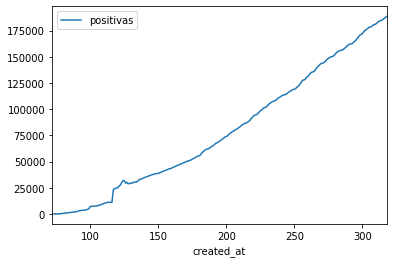

In [4]:
datos_infectados.plot(x = 'created_at', y = 'positivas')

Como se puede observar, el número de casos inicia el día 72 (13/03/2020) con 23 casos confirmados. Hasta el dia 318 (14/11/2020) se registran 188583 casos confirmados.

In [5]:
#Definición del modelo logístico
modelo_logistico = lambda x, a, b: a + b * np.log(x)

#Obtención de las variables para el entrenamiento
x = list(datos_infectados.iloc[:, 1]) #Fecha (Número de día)
y = list(datos_infectados.iloc[:, 0]) #Numero de infectados

#Realizamos el ajuste de curva para los datos
ajuste = curve_fit(modelo_logistico, x, y)

### 6) Verificación

La verificación de la implementación del modelo puede ser realizada mediante la ejecución paso a paso del propio cuaderno de python. En este caso no se han detectado errores, por lo que se prosigue al diseño de experimentos

### 7) Diseño de experimentos

Para probar el modelo se utilizara como premisa un periodo de predicción de 30 días posteriores a la fecha 14/11/2020. Al ser un modelo sencillo unicamente se realizara una simulación. 

### 8) Experimentación

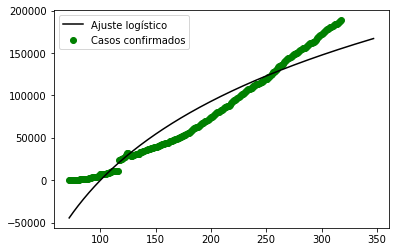

In [8]:
#Comprobación de la predicción para 30 días despues del 14/11/2020
dias = 30
x_real = list(range(min(x), max(x) + dias)) #Realizamos la predicción para un mes

plt.scatter(x, y, color = 'green')
plt.plot(x_real, [modelo_logistico(i, ajuste[0][0], ajuste[0][1]) for i in x_real], color = 'black')
plt.legend(('Ajuste logístico', 'Casos confirmados'))
plt.show()

### 9) Interpretación

De acuerdo a los parámetros de entrada de casos confirmados y fecha, se puede observar que el modelo no se ajusta correctamente los datos, por lo que seria conveniente buscar y utilizar otro tipo de función para predecir.

### 10) Implementación

Este proyecto no cuenta con interfaz gráfica de usuario externa, sin embargo, el usuario que desee ver el comportamiento del sistema cambiando el número de dias a predecir lo puede hacer modificando la variable 'dias' ubicada en In[25] de este cuaderno (Para el modelo logistico).

### 11) Uso del modelo lineal para el mismo conjunto de datos

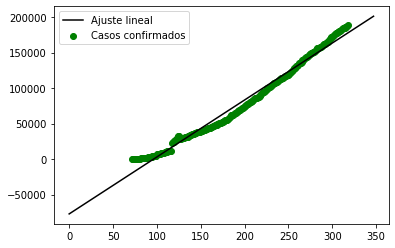

In [7]:
#Creación y entranamiento del modelo
modelo_lineal = linear_model.LinearRegression()
modelo_lineal.fit(np.array(x).reshape(-1, 1), y)

#Comprobación de la predicción para 30 días despues del 14/11/2020
dia = x[-1] + 30 #Se obtiene el dia a predecir sumando la ultima fecha registrada mas un mes
prediccion_semana = modelo_lineal.predict([[dia]])

#Gráfica de los datos y la predicción
x_real = np.array(range(0, 348))

plt.scatter(x, y , color = 'green')
plt.plot(x_real, modelo_lineal.predict(x_real.reshape(-1, 1)), color = 'black')
plt.legend(('Ajuste lineal', 'Casos confirmados'))
plt.show()

En este caso se muestra la reacción del modelo lineal ante el conjunto de datos.

### 12) Análisis

El modelo logístico utilizado para la muestra de datos presenta una curva que no se ajusta adecuadamente a esto, por lo que la predicción de casos en el futuro se ve equivocada por un margen de error considerable. Por el contrario al usar el modelo lineal se puede observar que si bien podria mejora, el ajuste es mejor que el del modelo logístico (Para esta muestra de datos).

### 13) Conclusiones

Mediante el presente trabajo se establece que de acuerdo a la comparativa realizada entre los modelos lógistico y lineal, el lineal es claramente mejor cuando el conjunto de muestras tiene una tendencia lineal y constante, mientras que el modelo logístico se recomienda para datos que presenten un gran crecimiento inicial y luego se vaya estabilizando con crecimiento moderado.

### 14) Criterio personal (Político, económico y social de la situación)

Debido a todo el caos que provoco el virus en todo el mundo, estos modelos de prediccon que si bien no son del todo exactos pueden ayudarnos a solventar algunas respuestas que todo la sociedad esta buscando, existen millones de empresas que de seguro estan desarrollando estos sistemas devido a la contingencia pero creo que ningunoo veneficia a la sociedad como la informacion como tal.